In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [5]:
# 3

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

# -------------------------------------------------------
# STEP 1: Create ImageDataGenerator objects
# -------------------------------------------------------
# These generators automatically read images from directories,
# rescale their pixel values, and prepare them as tensors for training.
# 'rescale=1.0/255' converts pixel values from 0–255 to 0–1 range.
train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)

# -------------------------------------------------------
# STEP 2: Load training images
# -------------------------------------------------------
# flow_from_directory() automatically labels subfolders (e.g., 'cats' and 'dogs').
# class_mode='binary' because there are two categories: cats (0) and dogs (1).
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# -------------------------------------------------------
# STEP 3: Load validation images
# -------------------------------------------------------
# This is used to evaluate model performance during training.
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# -------------------------------------------------------
# STEP 4: Prepare the test images
# -------------------------------------------------------
# The test folder doesn’t have subfolders, but flow_from_directory()
# expects at least one subfolder. We create a dummy subfolder ("test")
# and move all images into it the first time this cell runs.
test_subdir = os.path.join(test_dir, 'test')
if not os.path.exists(test_subdir):
    os.makedirs(test_subdir)
    for file in os.listdir(test_dir):
        file_path = os.path.join(test_dir, file)
        if os.path.isfile(file_path):
            shutil.move(file_path, test_subdir)

# -------------------------------------------------------
# STEP 5: Load the test images with the generator
# -------------------------------------------------------
# class_mode=None because test data has no labels.
# shuffle=False ensures predictions stay in the same order as the test files.
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


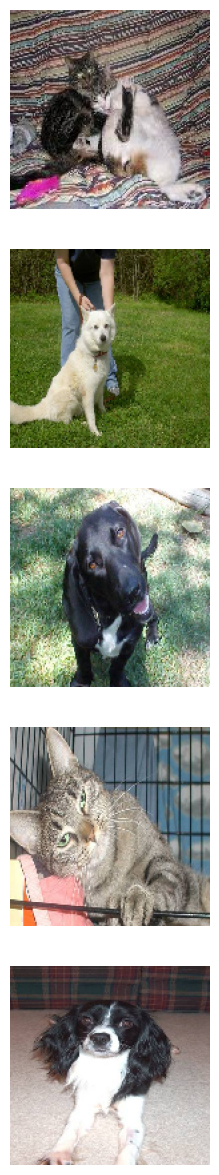

In [6]:
# 4

import matplotlib.pyplot as plt

# -------------------------------------------------------
# STEP 1: Define a helper function to display sample images
# -------------------------------------------------------
# This function takes an array of images and (optionally) a list of probabilities.
# If probabilities are provided, it will show the predicted label ("cat" or "dog")
# and the confidence percentage above each image.
def plotImages(images_arr, probabilities=False):
    # Create a vertical list of subplots equal to the number of images
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    # Case 1: When probabilities are not provided — just show the images
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')

    # Case 2: When probabilities are provided — show image + predicted label
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title(f"{probability*100:.2f}% dog")
            else:
                ax.set_title(f"{(1 - probability)*100:.2f}% cat")

    plt.show()

# -------------------------------------------------------
# STEP 2: Display a few random training images
# -------------------------------------------------------
# next(train_data_gen) returns a batch of images and labels.
# We only need the images for visualization.
sample_training_images, _ = next(train_data_gen)

# Display the first 5 training images from the batch
plotImages(sample_training_images[:5])



In [7]:
# 5

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------------------------------
# STEP 1: Recreate the train_image_generator with augmentation
# -------------------------------------------------------
# To help prevent overfitting (when the model memorizes training images),
# we use data augmentation — this creates slightly modified versions
# of existing images by applying random transformations.
# These transformations help the model generalize better.

train_image_generator = ImageDataGenerator(
    rescale=1.0/255,            # Always rescale pixel values to [0,1]
    rotation_range=45,          # Randomly rotate images up to 45 degrees
    width_shift_range=0.15,     # Randomly shift the image horizontally (15%)
    height_shift_range=0.15,    # Randomly shift the image vertically (15%)
    shear_range=0.2,            # Randomly apply shearing transformations
    zoom_range=0.2,             # Randomly zoom in/out on images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after rotation/shift
)

# This generator will later be used to create an augmented training dataset


Found 2000 images belonging to 2 classes.


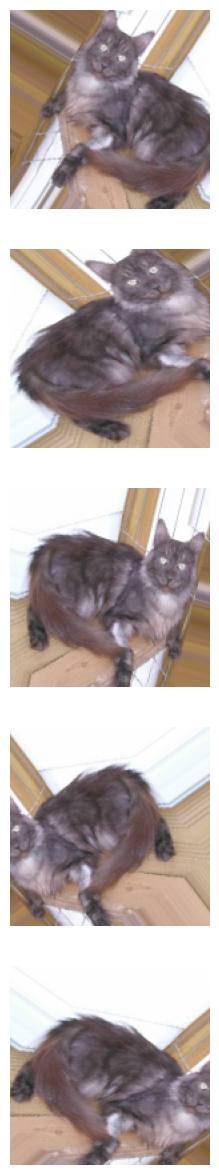

In [9]:
# 6

# Create a data generator that reads images from the training directory,
# applies the augmentations defined in train_image_generator, and outputs batches.
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,        # Number of images per batch
    directory=train_dir,          # Path to the training dataset
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize images to this shape
    class_mode='binary'           # For binary classification (0 or 1)
)

# Generate 5 different augmented versions of the first image in the first batch
# Even though we are using the same image, each iteration applies random transformations
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Plot the 5 augmented images to visualize the effects of the transformations
plotImages(augmented_images)


In [11]:
# 7

# Create a Sequential model
model = Sequential()

# Convolutional layer 1
# 32 filters, 3x3 kernel, ReLU activation, input shape must match your images
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# Max pooling layer 1 to reduce spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
# Max pooling layer 2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
# Max pooling layer 3
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the 3D feature maps to 1D before fully connected layers
model.add(Flatten())

# Fully connected (dense) layer with ReLU activation
model.add(Dense(128, activation='relu'))

# Output layer for binary classification
# Single neuron with sigmoid activation outputs probability of class 1
model.add(Dense(1, activation='sigmoid'))

# Print model summary to see the architecture and number of parameters
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 8

# Compile the model first
# - optimizer: Adam is commonly used for CNNs
# - loss: binary_crossentropy for binary classification
# - metrics: accuracy to monitor training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model using the training data generator
# - x: the train_data_gen generator
# - steps_per_epoch: how many batches per epoch (usually total_samples / batch_size)
# - epochs: number of passes over the entire dataset
# - validation_data: validation generator (assumes you have val_data_gen)
# - validation_steps: how many validation batches to evaluate per epoch
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=10,  # you can adjust based on dataset size
    validation_data=val_data_gen,  # make sure val_data_gen is defined
    validation_steps=val_data_gen.samples // batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - accuracy: 0.5166 - loss: 0.9847 - val_accuracy: 0.4989 - val_loss: 0.6820
Epoch 2/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:46 8s/step - accuracy: 0.5234 - loss: 0.6852

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5234 - loss: 0.6852 - val_accuracy: 0.5011 - val_loss: 0.6812
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.5470 - loss: 0.6840 - val_accuracy: 0.5647 - val_loss: 0.6718
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6750 - loss: 0.6476 - val_accuracy: 0.5938 - val_loss: 0.6647
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 0.5801 - loss: 0.6612 - val_accuracy: 0.5837 - val_loss: 0.6449
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5312 - loss: 0.6883 - val_accuracy: 0.6574 - val_loss: 0.6266
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.6324 - loss: 0.6320 - val_accuracy: 0.6429 - val_loss: 0.6173
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6328 - loss: 0.6365 - val_accuracy: 0.6562 - val_loss: 0.6140
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 9s/step - accuracy: 0.6470 - loss: 0.6375 - val_accuracy: 0.6685 - val_loss: 0.615

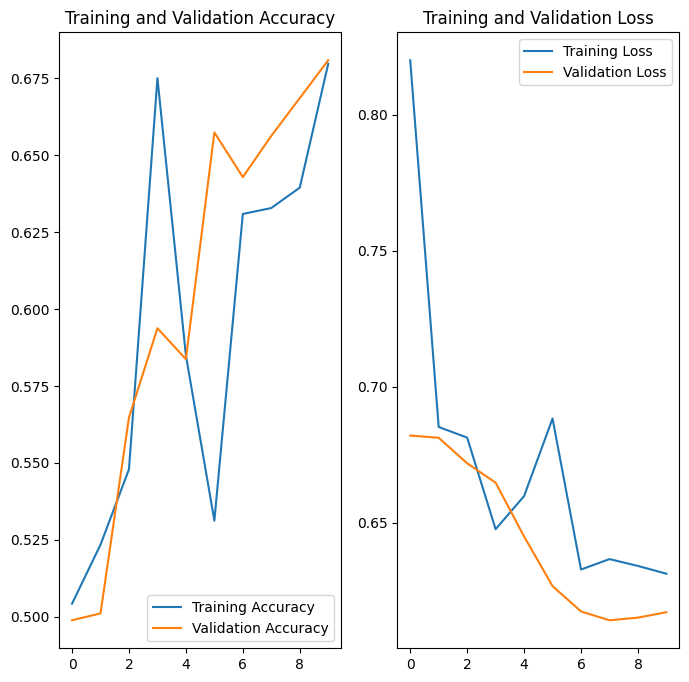

In [16]:
# 9

# Extract training and validation accuracy from the history object
acc = history.history['accuracy']        # Training accuracy per epoch
val_acc = history.history['val_accuracy']  # Validation accuracy per epoch

# Extract training and validation loss from the history object
loss = history.history['loss']           # Training loss per epoch
val_loss = history.history['val_loss']   # Validation loss per epoch

# Create a range object based on the actual number of epochs run
# This avoids mismatches if 'epochs' variable differs from the number of epochs actually trained
epochs_range = range(len(acc))

# Set up a figure with size 8x8 inches
plt.figure(figsize=(8, 8))

# ------------------ Accuracy Plot ------------------
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1 (left)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')                                # Add legend at lower right
plt.title('Training and Validation Accuracy')                # Title for subplot

# ------------------ Loss Plot ------------------
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2 (right)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')                               # Add legend at upper right
plt.title('Training and Validation Loss')                   # Title for subplot

# Display both plots
plt.show()




Found 50 images belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


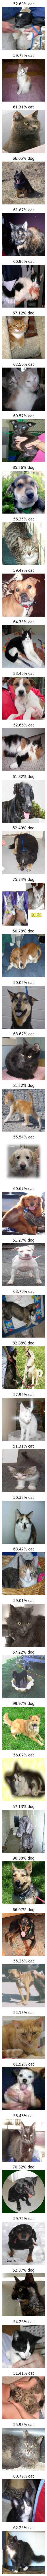

In [22]:
# 10

# Make sure test generator does NOT shuffle images
test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Important to match order with answers
)

# Step 1: Get predictions for all test images
pred_probs = model.predict(test_data_gen)  # Shape: (num_test_images, 1)

# Step 2: Keep probabilities as numeric values (0–1) for plotting
# This keeps the current plotImages function compatible
probabilities = [p[0] for p in pred_probs]

# Step 3: Collect all test images from generator
test_images = []
for batch in test_data_gen:
    if isinstance(batch, tuple) and len(batch) == 2:
        batch_images = batch[0]  # Only take images
    else:
        batch_images = batch
    test_images.extend(batch_images)

    # Stop when all images are collected
    if len(test_images) >= test_data_gen.samples:
        break

# Ensure the number of images matches the number of probabilities
test_images = test_images[:len(probabilities)]

# Step 4: Plot the test images with their numeric probabilities
# This keeps the existing plotImages function happy
plotImages(test_images, probabilities)


In [24]:
# 11

# List of correct labels for the 50 test images
# 1 = dog, 0 = cat
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

# Initialize a counter for correctly identified images
correct = 0

# Iterate over predicted probabilities and true labels
for probability, answer in zip(probabilities, answers):
    # Round probability to nearest integer (0 or 1) to get predicted class
    # Compare predicted class with the actual label
    if round(probability) == answer:
        correct += 1  # Increment counter if prediction is correct

# Calculate the percentage of correctly identified images
percentage_identified = (correct / len(answers)) * 100

# Determine if the challenge is passed (at least 63% accuracy required)
passed_challenge = percentage_identified >= 63

# Print the results
print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

# Print pass/fail message
if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
